In [1]:
import numpy as np
from copy import deepcopy
import dionysus as d
import scipy
import scipy.linalg
import pandas as pd
import gudhi as gd
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt


from Laplacian_Functions import *
from new_Laplacian_Functions import *
from Ren_Functions import *

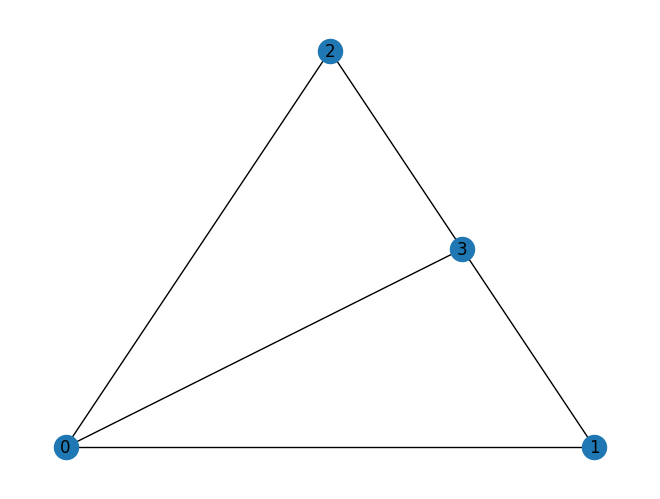

In [2]:
def create_cycle(n, overlap = 0, start_n=0, overlap_start = 0):
    simplices = []
    for v_i in range(n):
        if v_i < overlap:
            simplices.append(([v_i+overlap_start], 0))
            if v_i + 1 == overlap:
                simplices.append(([v_i+overlap_start, start_n], 1))
            else:
                simplices.append(([v_i+overlap_start, v_i+overlap_start+1], 1))
        elif v_i < n-1:
            simplices.append(([v_i+start_n-overlap], 0))
            simplices.append(([v_i+start_n-overlap, v_i+1+start_n-overlap], 1))
        else:
            simplices.append(([v_i+start_n-overlap], 0))
            # If you started with overlap, go to overlap_start. Otherwise go to start_n.
            simplices.append(([v_i+start_n-overlap, start_n*(overlap==0)+overlap_start*(overlap > 0)], 1))
    return simplices
    
def create_path(n, end_path = -1):
    if end_path < 0:
        end_path += n+1
    simplices = [([0], 0), ([end_path], 1)]
    for i in range(1,n):
        if i < end_path:
            simplices.append(([i], len(simplices)))
        else:
            simplices.append(([i+1], len(simplices)))
    for i in range(end_path-1):
        simplices.append(([i, i+1], len(simplices)))
    for i in range(end_path, n):
        simplices.append(([i, i+1], len(simplices)))
    simplices.append(([end_path-1, end_path], len(simplices)))
    return simplices
    

# Drawn
simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([1,0], 4), ([0,3], 5), ([1,3], 6), ([2,3], 7), ([0,2], 8), ([0,1,3], 9)]#, ([0,2,3], 10)]

# Swapped 7 and 8
# simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([1,0], 4), ([0,3], 5), ([1,3], 6), ([0,2], 7), ([2,3], 8), ([0,1,3], 9)]#, ([0,2,3], 10)]

# "Flipped"
# simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([0,1], 4), ([1,2], 5), ([0,2], 6), ([1,3], 7), ([2,3], 8), ([0,1,2], 9)]#, ([0,2,3], 10)]

# "Flipped", swapped d and e
# simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([0,1], 4), ([1,2], 5), ([0,2], 6), ([2,3], 7), ([1,3], 8), ([0,1,2], 9)]#, ([0,2,3], 10)]

# "Flipped", swapped b and c
# simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([0,1], 4), ([0,2], 5), ([1,2], 6), ([1,3], 7), ([2,3], 8), ([0,1,2], 9)]#, ([0,2,3], 10)]

# swapped 2 and 3
# simplices = [([0], 0), ([1], 1),  ([3], 2), ([2], 3),([0,1], 4), ([1,2], 5), ([0,2], 6), ([1,3], 7), ([2,3], 8), ([0,1,2], 9)]#, ([0,2,3], 10)]

# Non equidistant time intervals
# simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([1,0], 4), ([0,3], 8), ([1,3], 10), ([2,3], 10.1), ([0,2], 12), ([0,1,3], 12.5)]

# Ren paper
# simplices = [([0], 0), ([1], 0), ([2], 0), ([3], 0), ([0,2], 1), ([0,3], 1), ([2,3], 1), ([0,1], 2), ([0,2,3], 3)]

# Drawn new
# simplices = [([0], 0), ([1], 0), ([2], 0), ([3], 1), ([0,1], 2), ([1,2], 2), ([2,3], 2), ([0,2], 3), ([0,3], 3), ([4], 4), ([2,4], 5), ([3,4], 5), ([0,1,2], 6), ([2,3,4], 7), ([0,2,3], 8)]

# Test easy
# simplices = [([0], 0), ([1], 0), ([2], 0), ([0,1], 0), ([0,2], 0), ([1,2], 0),
#              ([3], 1), ([2,3], 1), ([1,3], 1), ([0,1,2], 1), ([1,2,3], 1)]

# Test hard
# simplices = [([0], 0), ([1], 0), ([2], 0), ([3], 0), ([0,1], 0), ([0,2], 0), ([1,3], 0), ([2,3], 0),
#               ([1,2], 1),  ([0,1,2], 1), ([1,2,3], 1)]

# Example PowerPoint
# simplices = [([0],0), ([1], 0), ([2], 1), ([3], 1), ([4], 1), ([0,2], 1), ([2,3], 1), ([2,4], 1), ([3,4], 1), ([1,4], 1)]

# Path
# simplices = create_path(8, end_path=-1)

# Cycles
x = 4
y = 4
z = 4
x4 = 5
overlap = 3
# Three cycles added in order x->y->z, with x and z not connected.
# simplices = create_cycle(x) + create_cycle(y, start_n=x, overlap=overlap, overlap_start=x-overlap) + create_cycle(z, start_n=x+y-overlap, overlap=overlap, overlap_start=x+y-2*overlap)
# Three cycles added with all of them connecting on overlap vertices.
# simplices = create_cycle(x) + create_cycle(y, start_n=x, overlap=overlap) + create_cycle(z, start_n=x+y-overlap, overlap=overlap)
# simplices = create_cycle(x) + create_cycle(y, start_n=x, overlap=overlap) + create_cycle(z, start_n=x+y-overlap, overlap=overlap)+ create_cycle(x4, start_n=x+y+z-2*overlap, overlap=overlap)
# simplices.append(([7], 0))
# simplices.append(([6,7], 1))
# simplices = create_cycle(7)
# simplices.append(([10], 2))
# simplices.append(([0,2], 2))
# simplices.append(([0,1,2], 2))
# simplices.append(([0,3], 3))
# simplices.append(([0,2,3], 3))
# print(simplices)

f = d.Filtration()
for vertices, time in simplices:
    f.append(d.Simplex(vertices, time))

# Drawing graph
G = nx.Graph()
f.sort()
for s in f:
    if s.dimension() == 0:
        G.add_node(s[0])
    elif s.dimension() == 1:
        G.add_edge(s[0], s[1])
nx.draw_planar(G, with_labels=True)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

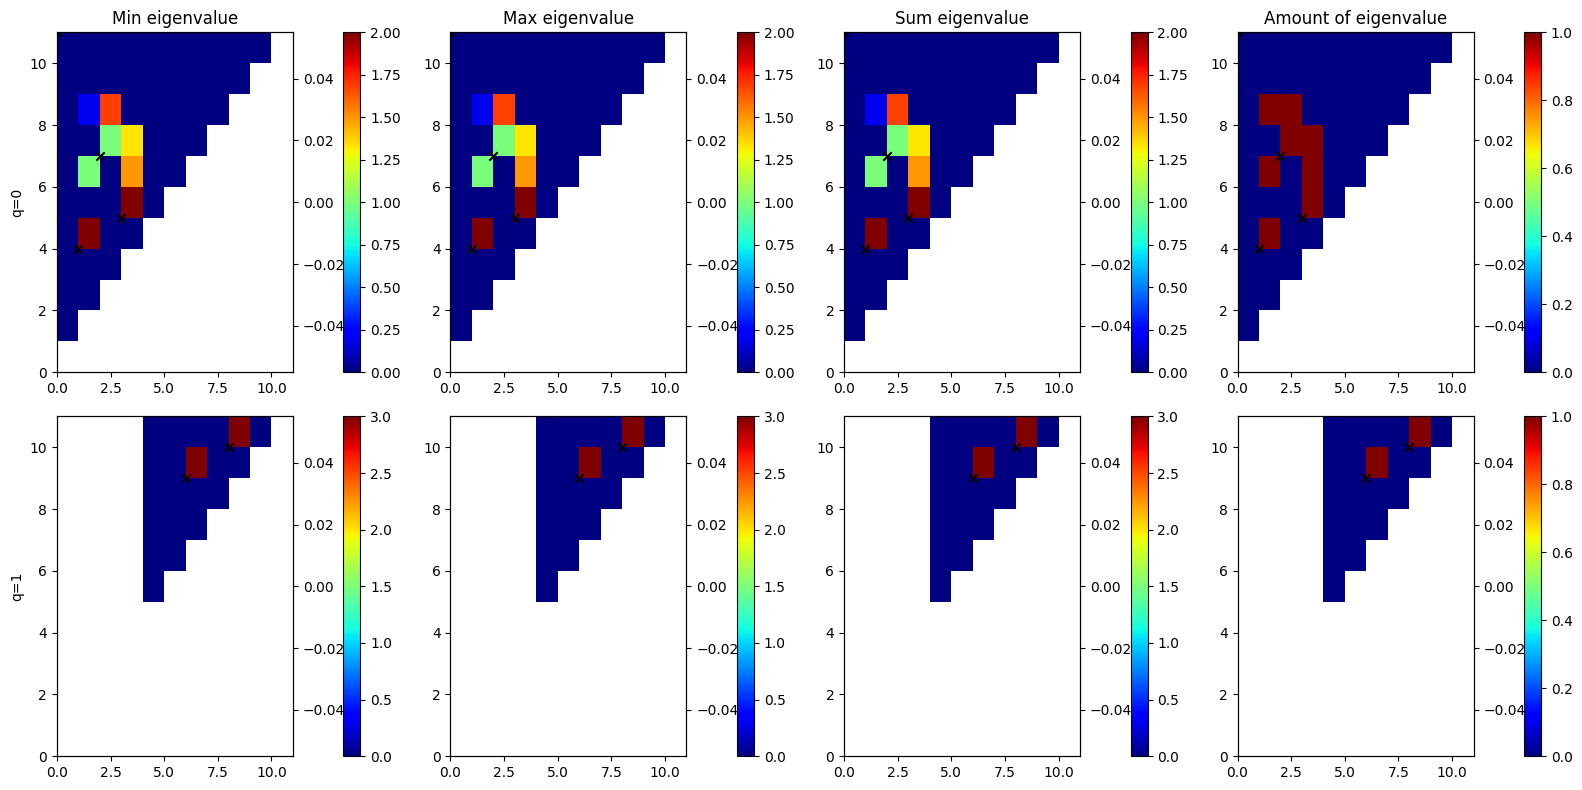

In [3]:
eigenvalues, relevant_times, fig, ax = plot_Laplacian_new_eigenvalues(f, lambda x: 1, plot_types=["Min", "Max", "Sum", "Amount of"], method="cross_extended", plot_args_diag={"c": "black", "alpha": 1, "marker": "x"}, plot_type_to_fun={"Amount of": len})

In [5]:
cross_Lap = calc_cross_extended(f, 0, 2, 8, verb=True)
print(f"Cross_Lap\n{np.round(cross_Lap, 5)}")
evals, evecs = np.linalg.eigh(cross_Lap)
for i, eval in enumerate(evals):
    # if np.abs(eval) > 1e-8:
    print("eval:", eval)
    evec = evecs[:,i]
    print("normalized evec", np.round(evec, 5))
    print("denormalized evec",np.round(evec/np.min(np.abs(evec[np.abs(evec) > 1e-8])),5))
    print()

Bqplus1:
[[-1. -1.  0.  0. -1.]
 [ 1.  0. -1.  0.  0.]
 [ 0.  0.  0. -1.  1.]
 [ 0.  1.  1.  1.  0.]]
n_q_t:[4, 5, 0], n_q_s: [3, 0, 0]
B12_st:
[[-1. -1.  0.  0. -1.]
 [ 1.  0. -1.  0.  0.]
 [ 0.  0.  0. -1.  1.]]
B22_st:
[[0. 1. 1. 1. 0.]]
B22_stm1:
[[0. 1. 1. 1.]]
B22_sm1t:
[[ 0.  0.  0. -1.  1.]
 [ 0.  1.  1.  1.  0.]]
B22_sm1tm1:
[[ 0.  0.  0. -1.]
 [ 0.  1.  1.  1.]]
B22_mult_tm1sm1:
[[ 0.       0.       0.       0.       0.     ]
 [ 0.       0.33333  0.33333  0.33333 -0.     ]
 [ 0.       0.33333  0.33333  0.33333 -0.     ]
 [ 0.       0.33333  0.33333  0.33333 -0.     ]
 [ 0.       0.2      0.2     -0.4      0.6    ]]
B22_mult_tm1sm1^2:
[[ 0.       0.       0.       0.       0.     ]
 [ 0.       0.33333  0.33333  0.33333 -0.     ]
 [ 0.       0.33333  0.33333  0.33333 -0.     ]
 [ 0.       0.33333  0.33333  0.33333 -0.     ]
 [ 0.       0.12     0.12    -0.24     0.36   ]]
B22_mult_sm1tm1:
[[ 0.       0.       0.       0.       0.     ]
 [ 0.       0.33333  0.33333  0.33333  0.2

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

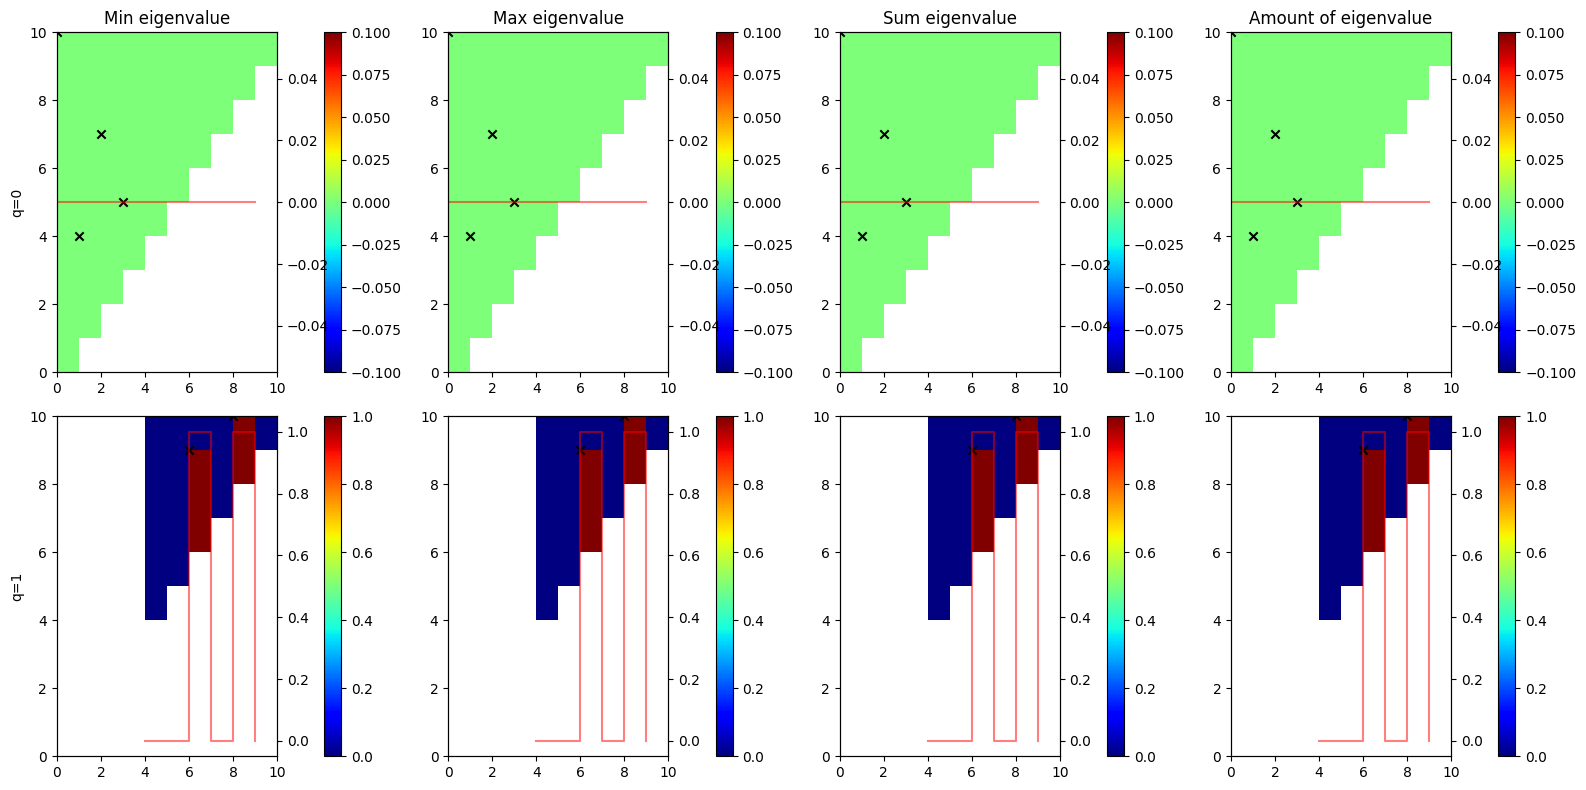

In [3]:
eigenvalues, relevant_times, fig, ax = plot_Laplacian_new_eigenvalues(f, lambda x: 1, plot_types=["Min", "Max", "Sum", "Amount of"], method="vertical_extended", plot_args_diag={"c": "black", "alpha": 1, "marker": "x"}, plot_type_to_fun={"Amount of": len})

In [5]:
cross_Lap = calc_vertical_extended(f, 1, 8, 9, verb=True)
print(f"Cross_Lap\n{np.round(cross_Lap, 5)}")
evals, evecs = np.linalg.eigh(cross_Lap)
for i, eval in enumerate(evals):
    # if np.abs(eval) > 1e-8:
    print("eval:", eval)
    evec = evecs[:,i]
    print(np.round(evec, 5))
    print(np.round(evec/np.min(np.abs(evec[np.abs(evec) > 1e-8])),5))
    print()

Bqplus1:
[[ 1.]
 [-1.]
 [ 1.]
 [ 0.]
 [ 0.]]
n_q_t:[4, 5, 1], n_q_s: [4, 5, 0]
Down Lap:
[[ 0.04166667  0.08333333  0.04166667 -0.125      -0.125     ]
 [ 0.08333333  0.16666667  0.08333333 -0.25       -0.25      ]
 [ 0.04166667  0.08333333  0.04166667 -0.125      -0.125     ]
 [-0.125      -0.25       -0.125       0.375       0.375     ]
 [-0.125      -0.25       -0.125       0.375       0.375     ]]
eval: -0.0, evec: [23.68115 19.43836  1.10679  1.      20.22155]
eval: -0.0, evec: [-2.74518  4.59056  1.       3.92543 -1.44678]
eval: -0.0, evec: [-1.81189  1.44551 -3.31365 -1.74484  1.     ]
eval: 0.0, evec: [-7.7956   1.      10.43751 -6.36418  7.91148]
eval: 1.0, evec: [ 1.  2.  1. -3. -3.]
8 9
B12_st:
[[ 1.]
 [-1.]
 [ 1.]
 [ 0.]
 [ 0.]]
B22_st:
[]
B22_stm1:
[]
B22_sm1t:
[[0.]]
B22_sm1tm1:
[]
up_Lap:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
eval: 0.0, evec: [1. 0. 0. 0. 0.]
eval: 0.0, evec: [0. 1. 0. 0. 0.]
eval: 0.0, evec: [0. 0. 1.

Computing laplacians...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Computing eigenvalues...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

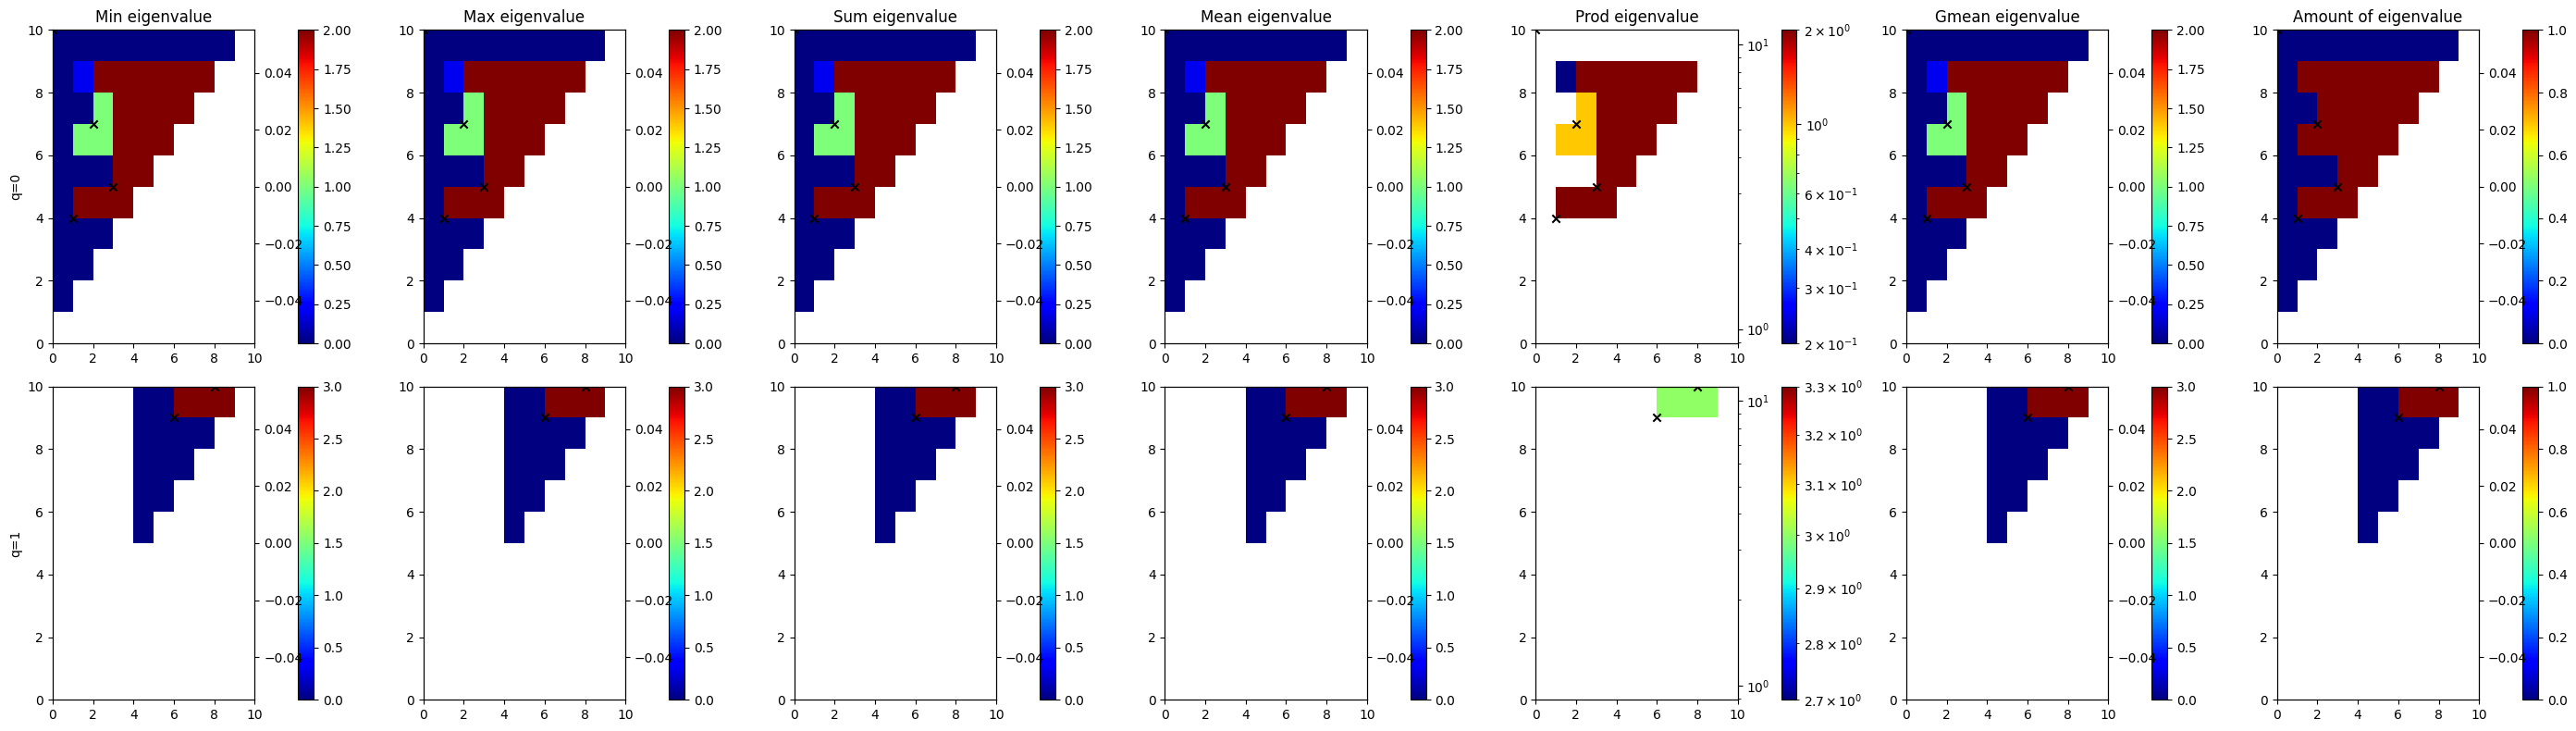

In [6]:
eigenvalues, relevant_times, fig, ax = plot_Laplacian_eigenvalues(f, lambda x: 1, plot_types="all", plot_args_diag={"c": "black", "alpha": 1, "marker": "x"}, laplacian_type="cross", plot_type_to_fun={"Amount of": len})

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

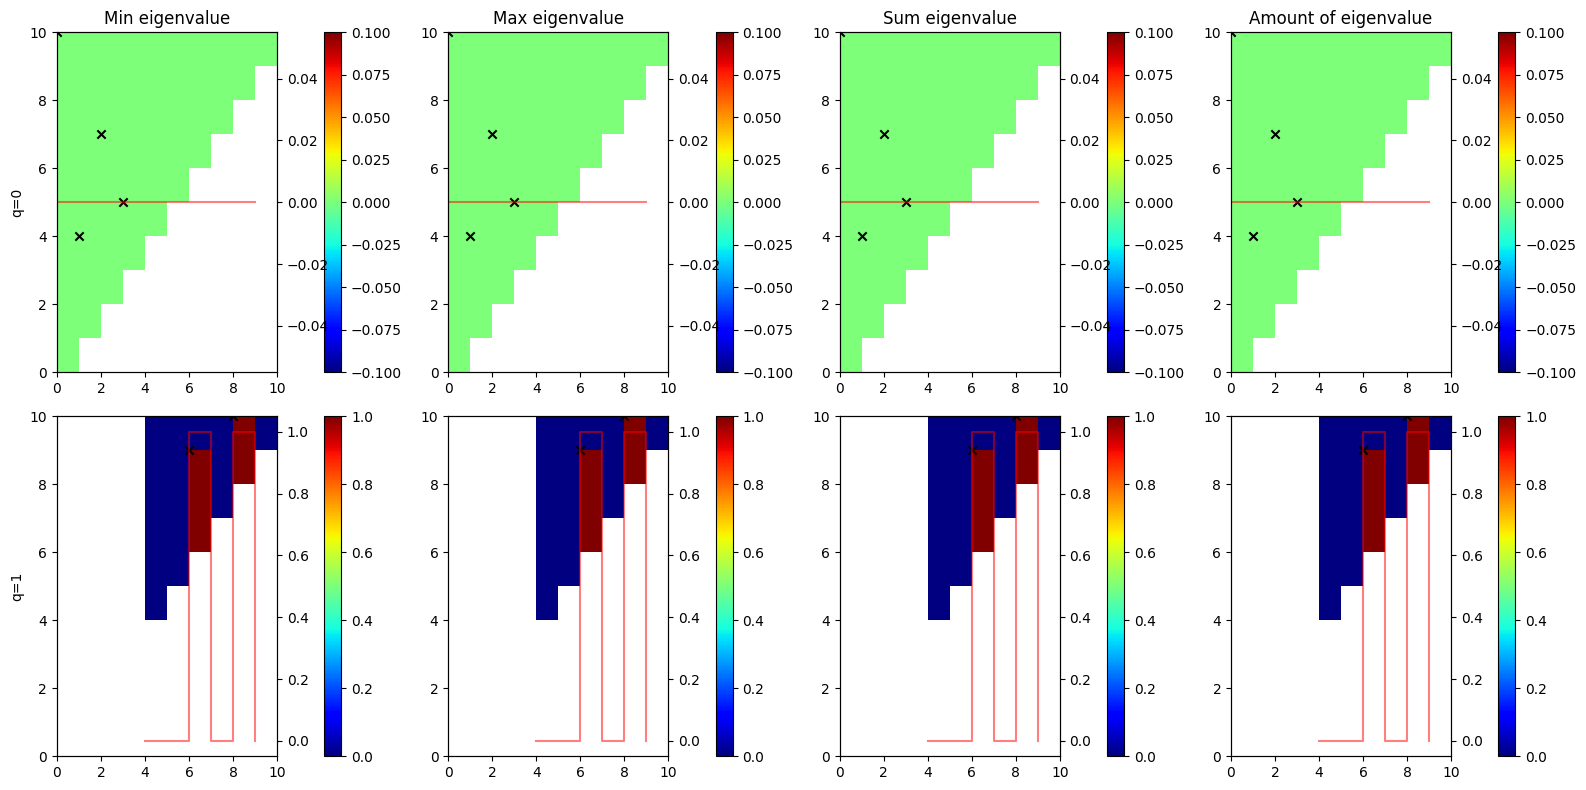

In [10]:
def weight_fun(x):
    v = x.split(",")
    if "1" in v:
        return 2**len(v)
    return 1

eigenvalues, relevant_times, fig, ax = plot_Laplacian_new_eigenvalues(f, weight_fun, plot_types=["Min", "Max", "Sum", "Amount of"], method="vertical_extended", plot_args_diag={"c": "black", "alpha": 1, "marker": "x"}, plot_type_to_fun={"Amount of": len})

(<Figure size 1200x800 with 18 Axes>,
 array([[<Axes: title={'center': 'Min eigenvalue'}, ylabel='q=0'>,
         <Axes: title={'center': 'Max eigenvalue'}>,
         <Axes: title={'center': 'Amount of eigenvalue'}>],
        [<Axes: ylabel='q=1'>, <Axes: >, <Axes: >]], dtype=object))

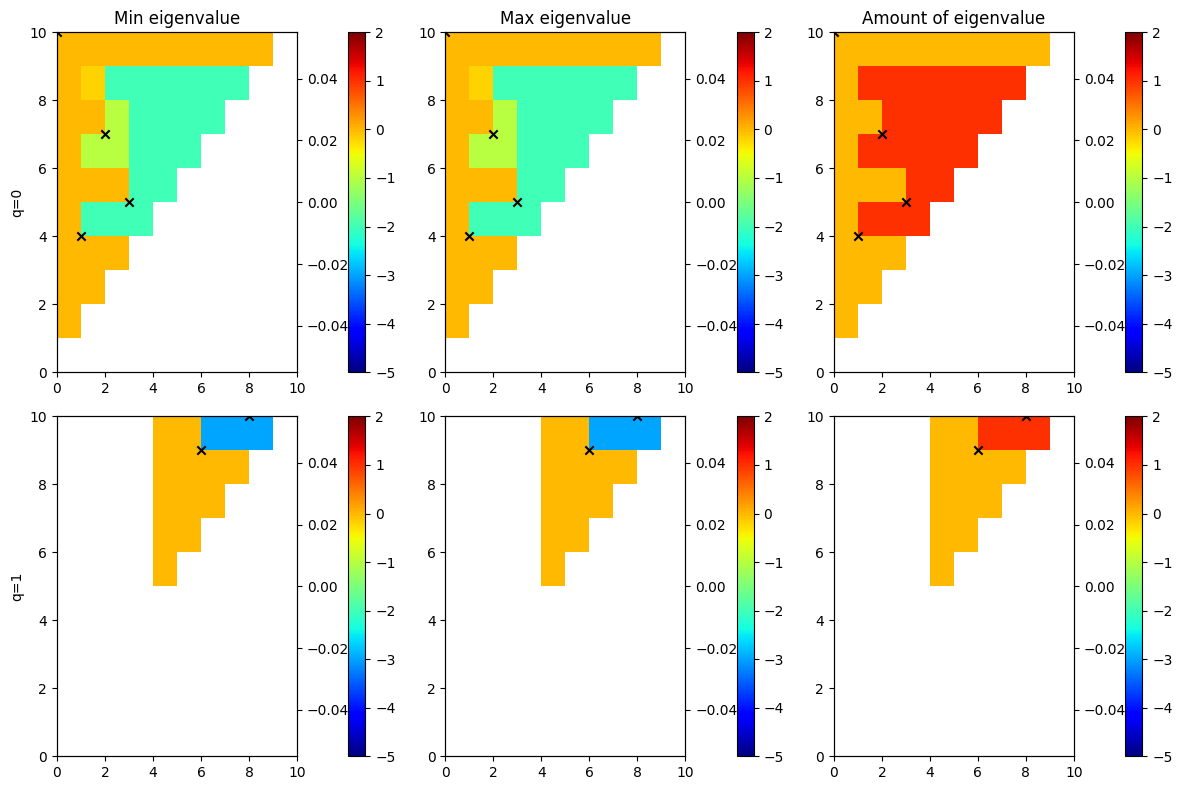

In [17]:
plot_eigenvalues(eigenvalues=eigenvalues, relevant_times=relevant_times, filtration=f, plot_args_mesh={"vmin": -5, "vmax": 2} , plot_args_diag={"c": "black", "alpha": 1, "marker": "x"}, plot_type_to_fun={"Amount of": len}, plot_types=["Min", "Max", "Amount of"])

(<Figure size 1200x800 with 18 Axes>,
 array([[<Axes: title={'center': 'Min eigenvalue'}, ylabel='q=0'>,
         <Axes: title={'center': 'Max eigenvalue'}>,
         <Axes: title={'center': 'Amount of eigenvalue'}>],
        [<Axes: ylabel='q=1'>, <Axes: >, <Axes: >]], dtype=object))

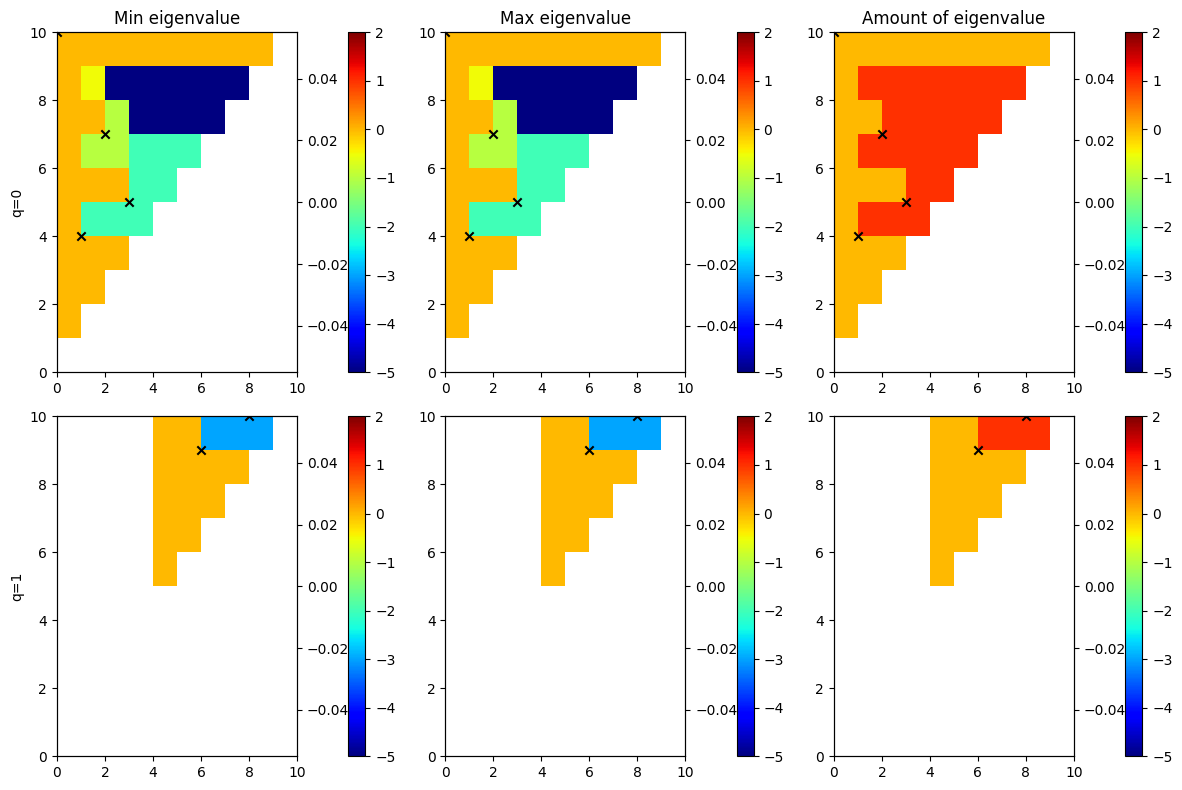

In [19]:
plot_eigenvalues(eigenvalues=eigenvalues, relevant_times=relevant_times, filtration=f, plot_args_mesh={"vmin": -5, "vmax": 2} , plot_args_diag={"c": "black", "alpha": 1, "marker": "x"}, plot_type_to_fun={"Amount of": len}, plot_types=["Min", "Max", "Amount of"])

In [18]:
A = np.eye(3)
b = np.zeros((4,4))
b[:A.shape[0],:A.shape[1]] = A
b

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.]])

In [7]:
path_length = 5
k = 4
simplices = create_path(path_length, end_path=k)
simplices.append(([1, k], 2*path_length+1))
# simplices.append(([path_length+1], 0))
# simplices.append(([path_length+2], 0))
# simplices.append(([0,path_length+1], 0))
# simplices.append(([0,path_length+2], 0))
# simplices.append(([path_length+1,path_length+2], 0))
print(simplices)
f = d.Filtration()
for vertices, time in simplices:
    f.append(d.Simplex(vertices, time))
f.sort()
final_time = f[len(f)-1].data
Lap = compute_cross_Laplacian(f, q=0, s=1, t=final_time, weight_fun= lambda x: 1, verb=False)
print(Lap)
evals = np.linalg.eigvalsh(Lap)
print(np.round(evals, 5))
np.prod(evals[evals > 1e-8])


[([0], 0), ([4], 1), ([1], 2), ([2], 3), ([3], 4), ([5], 5), ([0, 1], 6), ([1, 2], 7), ([2, 3], 8), ([4, 5], 9), ([3, 4], 10), ([1, 4], 11)]
[[-0.32142857  0.32142857]
 [ 0.32142857 -0.32142857]]
[-0.64286 -0.     ]


1.0

In [10]:
1/k+(1/np.sqrt(2)-1/(k*np.sqrt(2)))**2/(1-1/(2*k))

0.5714285714285714

In [19]:
9/28

0.32142857142857145

In [ ]:
Lap = compute_Laplacian(f, q=0, s=2, t=2, weight_fun= lambda x: 1)
print(Lap)
evals, evecs = np.linalg.eigh(Lap)
for i, eval in enumerate(evals):
    print("eval:", eval)
    aevec = np.abs(evecs[:,i])
    print(np.round(evecs[:, i]/np.min(aevec[aevec>1e-8]),5))
np.prod(evals[evals > 1e-8])

[[ 3. -1. -1. -1.]
 [-1.  2. -1.  0.]
 [-1. -1.  2.  0.]
 [-1.  0.  0.  1.]]
eval: 1.1102230246251565e-16
[1. 1. 1. 1.]
eval: 1.0000000000000002
[ 0.  1.  1. -2.]
eval: 2.9999999999999987
[-0. -1.  1. -0.]
eval: 4.0
[-3.  1.  1.  1.]


11.999999999999996

In [5]:
def weight_fun(x):
    v = x.split(",")
    p = 1
    # if "2" in v:
    #     return 2
    # if "0" in v:
    #     p *= 2#**(len(v)/2)
    # if "3" in v:
    #     p *= 3#**(len(v)/2)
    return p


Lap = compute_Laplacian(f, 1, 4, 4, weight_fun, verb=True)
print("Lap:\n", Lap)
eval, evec = np.linalg.eig(Lap)
for i in range(len(eval)):
    print(f"eval: {np.round(eval[i], 2)}, evec: {np.round(evec[:,i]/np.min(np.abs(evec[:,i][np.abs(evec[:,i]) > 1e-8])),2)}", )

upL:
 [[0.]]
eval: 0.0, evec: [1.]
Product of eigenvalues: 1

downL:
 [[2.]]
eval: 2.0, evec: [1.]
Product of eigenvalues: 2.0

Lap:
 [[2.]]
eval: 2.0, evec: [1.]


In [10]:
def weight_fun(x):
    if "1" in x:
        return 1
    return 1


barcodes_df = complete_analysis_fast(f, weight_fun)
# print(np.round(barcodes_df.loc[2, "p_ij"], 2))
barcodes_df.apply(lambda x: x.apply(lambda y: np.round(y, 2) if y is not None else None).apply(lambda y: np.sort(y) if type(y) == np.ndarray else y), axis=1).groupby("q").apply(display, include_groups=False)


,birth,death,multiplicity,eigenvalues_ijm1,eigenvalues_ij,eigenvalues_im1jm1,eigenvalues_im1j,p_ijm1,p_ij,p_im1jm1,p_im1j
0,1.0,4.0,1,"[0.0, 0.0]","[0.0, 2.0]",[0.0],[0.0],1.0,2.0,1.0,1.0
1,3.0,5.0,1,"[0.0, 0.0, 0.0, 2.0]","[-0.0, 0.0, 1.0, 3.0]","[0.0, 0.0, 2.0]","[0.0, 0.0, 2.0]",2.0,3.0,2.0,2.0
2,2.0,7.0,1,"[0.0, 0.0, 3.0]","[-0.0, 1.0, 3.0]","[0.0, 3.0]","[0.0, 3.0]",3.0,3.0,3.0,3.0
3,0.0,inf,1,[0.0],[0.0],[],[],1.0,1.0,1.0,1.0


,birth,death,multiplicity,eigenvalues_ijm1,eigenvalues_ij,eigenvalues_im1jm1,eigenvalues_im1j,p_ijm1,p_ij,p_im1jm1,p_im1j
4,6.0,9.0,1,"[0.0, 3.0, 3.0]","[3.0, 3.0, 3.0]","[1.0, 3.0]","[1.0, 3.0]",9.0,27.0,3.0,3.0
5,8.0,inf,1,"[-0.0, 0.0, 2.0, 4.0, 4.0]","[-0.0, 2.0, 3.0, 4.0, 4.0]","[-0.0, 1.0, 3.0, 4.0]","[1.0, 3.0, 3.0, 4.0]",32.0,96.0,12.0,36.0


""


[[ 2.  1. -1.  0.  0.  0.]
 [ 1.  2.  0.  0.  0.  1.]
 [-1.  0.  2. -1.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0. -1.  2. -1.]
 [ 0.  1.  0.  0. -1.  2.]]
[-1.11022302e-16  1.00000000e+00  4.00000000e+00  3.00000000e+00
  1.00000000e+00  3.00000000e+00]
<0> 0 - <1> 0 - <2> 0 - <3> 0 - <4> 0 - <5> 0 - <0,1> 1 - <0,5> 1 - <1,2> 1 - <2,3> 1 - <3,4> 1 - <4,5> 1 - 

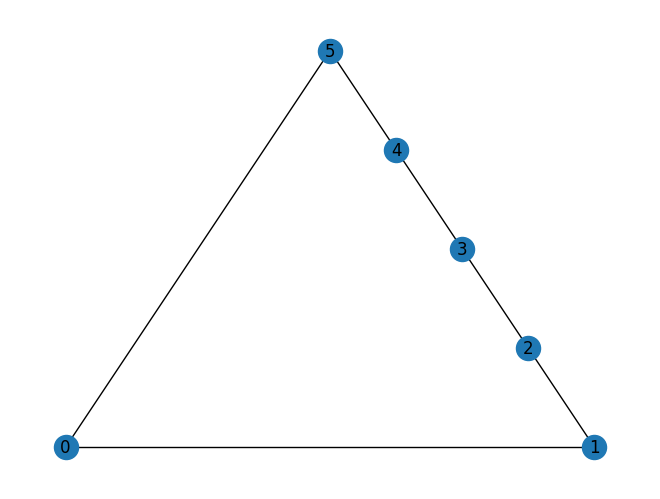

In [188]:
x=6
simplices = create_cycle(x)
f = d.Filtration()
for vertices, time in simplices:
    f.append(d.Simplex(vertices, time))

Lap = compute_Laplacian(f, 1, 1, 1, lambda x: 1)
print(Lap)
print(np.linalg.eig(Lap)[0])
G = nx.Graph()
f.sort()
for s in f:
    print(s, end=" - ")
    if s.dimension() == 0:
        G.add_node(s[0])
    elif s.dimension() == 1:
        G.add_edge(s[0], s[1])
nx.draw_planar(G, with_labels=True)

In [185]:
# A = np.array([[2,-1,0,0,-1],
#               [-1,2,-1,0,0],
#               [0,-1,2,-1,0],
#               [0,0,-1,2,-1],
#               [-1,0,0,-1,2]])
A = np.array([[2,-1,0,-1],
              [-1,2,-1,0],
              [0,-1,2,-1],
              [-1,0,-1,2]])
np.linalg.eig(A)

EigResult(eigenvalues=array([-6.66133815e-16,  2.00000000e+00,  4.00000000e+00,  2.00000000e+00]), eigenvectors=array([[ 5.00000000e-01,  7.07106781e-01, -5.00000000e-01,
         5.55111512e-17],
       [ 5.00000000e-01, -2.74466000e-16,  5.00000000e-01,
        -7.07106781e-01],
       [ 5.00000000e-01, -7.07106781e-01, -5.00000000e-01,
         2.58507341e-16],
       [ 5.00000000e-01,  3.08103393e-17,  5.00000000e-01,
         7.07106781e-01]]))

In [ ]:
n=4


1.9999999999999996

In [13]:
import sklearn
import sklearn.linear_model
overlap = 0

results = {}
results_np = []
amount_good = 0

for z in range(2*overlap+2, 10+2*overlap):
    results[z] = {}
    for x in range(2*overlap+2, 10+2*overlap):
        results[z][x] = {}
        for y in range(2*overlap+2, 10+2*overlap):
            # Three cycles added in order x->y->z, with x and z not connected.
            # simplices = create_cycle(x) + create_cycle(y, start_n=x, overlap=overlap, overlap_start=x-overlap) + create_cycle(z, start_n=x+y-overlap, overlap=overlap, overlap_start=x+y-2*overlap)
            # Three cycles added with all of them connecting on overlap vertices.
            simplices = create_cycle(x) + create_cycle(y, start_n=x, overlap=overlap) + create_cycle(z, start_n=x+y-overlap, overlap=overlap)
            f = d.Filtration()
            for vertices, time in simplices:
                f.append(d.Simplex(vertices, time))
            Lap = compute_Laplacian(f, 1, 1, 1, lambda x: 1)
            positive_evals = [i for i in np.linalg.eig(Lap)[0] if i > 1e-8]
            res = 1
            for eval in positive_evals:
                res *= eval
            res = res.real
            # barcodes_df = complete_analysis_fast(f, weight_fun)
            # res = (np.round(barcodes_df.loc[2, "p_ij"], 2)).real
            results[z][x][y] = (res)
            results_np.append([x**2*y*z, x*y**2*z, x*y*z**2, x*y*z, x**2, y**2, z**2, x*y, x*z, y*z, x,y,z,res])
    print(f"z={z}")
    display(pd.DataFrame(results[z]))
# results_np = np.array(results_np)
# linear_model = sklearn.linear_model.LinearRegression()
# linear_model.fit(results_np[:, :-1], results_np[:, -1])
# print(f"Coefficients: {np.round(linear_model.coef_, 2)}, intercept: {linear_model.intercept_}")
# print("Certainty:",linear_model.score(results_np[:, :-1], results_np[:, -1]))

z=2


,2,3,4,5,6,7,8,9
2,8.0,36.0,64.0,100.0,144.0,196.0,256.0,324.0
3,36.0,162.0,288.0,450.0,648.0,882.0,1152.0,1458.0
4,64.0,288.0,512.0,800.0,1152.0,1568.0,2048.0,2592.0
5,100.0,450.0,800.0,1250.0,1800.0,2450.0,3200.0,4050.0
6,144.0,648.0,1152.0,1800.0,2592.0,3528.0,4608.0,5832.0
7,196.0,882.0,1568.0,2450.0,3528.0,4802.0,6272.0,7938.0
8,256.0,1152.0,2048.0,3200.0,4608.0,6272.0,8192.0,10368.0
9,324.0,1458.0,2592.0,4050.0,5832.0,7938.0,10368.0,13122.0


z=3


,2,3,4,5,6,7,8,9
2,36.0,162.0,288.0,450.0,648.0,882.0,1152.0,1458.0
3,162.0,729.0,1296.0,2025.0,2916.0,3969.0,5184.0,6561.0
4,288.0,1296.0,2304.0,3600.0,5184.0,7056.0,9216.0,11664.0
5,450.0,2025.0,3600.0,5625.0,8100.0,11025.0,14400.0,18225.0
6,648.0,2916.0,5184.0,8100.0,11664.0,15876.0,20736.0,26244.0
7,882.0,3969.0,7056.0,11025.0,15876.0,21609.0,28224.0,35721.0
8,1152.0,5184.0,9216.0,14400.0,20736.0,28224.0,36864.0,46656.0
9,1458.0,6561.0,11664.0,18225.0,26244.0,35721.0,46656.0,59049.0


z=4


,2,3,4,5,6,7,8,9
2,64.0,288.0,512.0,800.0,1152.0,1568.0,2048.0,2592.0
3,288.0,1296.0,2304.0,3600.0,5184.0,7056.0,9216.0,11664.0
4,512.0,2304.0,4096.0,6400.0,9216.0,12544.0,16384.0,20736.0
5,800.0,3600.0,6400.0,10000.0,14400.0,19600.0,25600.0,32400.0
6,1152.0,5184.0,9216.0,14400.0,20736.0,28224.0,36864.0,46656.0
7,1568.0,7056.0,12544.0,19600.0,28224.0,38416.0,50176.0,63504.0
8,2048.0,9216.0,16384.0,25600.0,36864.0,50176.0,65536.0,82944.0
9,2592.0,11664.0,20736.0,32400.0,46656.0,63504.0,82944.0,104976.0


z=5


,2,3,4,5,6,7,8,9
2,100.0,450.0,800.0,1250.0,1800.0,2450.0,3200.0,4050.0
3,450.0,2025.0,3600.0,5625.0,8100.0,11025.0,14400.0,18225.0
4,800.0,3600.0,6400.0,10000.0,14400.0,19600.0,25600.0,32400.0
5,1250.0,5625.0,10000.0,15625.0,22500.0,30625.0,40000.0,50625.0
6,1800.0,8100.0,14400.0,22500.0,32400.0,44100.0,57600.0,72900.0
7,2450.0,11025.0,19600.0,30625.0,44100.0,60025.0,78400.0,99225.0
8,3200.0,14400.0,25600.0,40000.0,57600.0,78400.0,102400.0,129600.0
9,4050.0,18225.0,32400.0,50625.0,72900.0,99225.0,129600.0,164025.0


z=6


,2,3,4,5,6,7,8,9
2,144.0,648.0,1152.0,1800.0,2592.0,3528.0,4608.0,5832.0
3,648.0,2916.0,5184.0,8100.0,11664.0,15876.0,20736.0,26244.0
4,1152.0,5184.0,9216.0,14400.0,20736.0,28224.0,36864.0,46656.0
5,1800.0,8100.0,14400.0,22500.0,32400.0,44100.0,57600.0,72900.0
6,2592.0,11664.0,20736.0,32400.0,46656.0,63504.0,82944.0,104976.0
7,3528.0,15876.0,28224.0,44100.0,63504.0,86436.0,112896.0,142884.0
8,4608.0,20736.0,36864.0,57600.0,82944.0,112896.0,147456.0,186624.0
9,5832.0,26244.0,46656.0,72900.0,104976.0,142884.0,186624.0,236196.0


z=7


,2,3,4,5,6,7,8,9
2,196.0,882.0,1568.0,2450.0,3528.0,4802.0,6272.0,7938.0
3,882.0,3969.0,7056.0,11025.0,15876.0,21609.0,28224.0,35721.0
4,1568.0,7056.0,12544.0,19600.0,28224.0,38416.0,50176.0,63504.0
5,2450.0,11025.0,19600.0,30625.0,44100.0,60025.0,78400.0,99225.0
6,3528.0,15876.0,28224.0,44100.0,63504.0,86436.0,112896.0,142884.0
7,4802.0,21609.0,38416.0,60025.0,86436.0,117649.0,153664.0,194481.0
8,6272.0,28224.0,50176.0,78400.0,112896.0,153664.0,200704.0,254016.0
9,7938.0,35721.0,63504.0,99225.0,142884.0,194481.0,254016.0,321489.0


z=8


,2,3,4,5,6,7,8,9
2,256.0,1152.0,2048.0,3200.0,4608.0,6272.0,8192.0,10368.0
3,1152.0,5184.0,9216.0,14400.0,20736.0,28224.0,36864.0,46656.0
4,2048.0,9216.0,16384.0,25600.0,36864.0,50176.0,65536.0,82944.0
5,3200.0,14400.0,25600.0,40000.0,57600.0,78400.0,102400.0,129600.0
6,4608.0,20736.0,36864.0,57600.0,82944.0,112896.0,147456.0,186624.0
7,6272.0,28224.0,50176.0,78400.0,112896.0,153664.0,200704.0,254016.0
8,8192.0,36864.0,65536.0,102400.0,147456.0,200704.0,262144.0,331776.0
9,10368.0,46656.0,82944.0,129600.0,186624.0,254016.0,331776.0,419904.0


z=9


,2,3,4,5,6,7,8,9
2,324.0,1458.0,2592.0,4050.0,5832.0,7938.0,10368.0,13122.0
3,1458.0,6561.0,11664.0,18225.0,26244.0,35721.0,46656.0,59049.0
4,2592.0,11664.0,20736.0,32400.0,46656.0,63504.0,82944.0,104976.0
5,4050.0,18225.0,32400.0,50625.0,72900.0,99225.0,129600.0,164025.0
6,5832.0,26244.0,46656.0,72900.0,104976.0,142884.0,186624.0,236196.0
7,7938.0,35721.0,63504.0,99225.0,142884.0,194481.0,254016.0,321489.0
8,10368.0,46656.0,82944.0,129600.0,186624.0,254016.0,331776.0,419904.0
9,13122.0,59049.0,104976.0,164025.0,236196.0,321489.0,419904.0,531441.0


In [14]:
overlap = 1

results_np = []
results = {}

add_to = 0
for x in range(overlap+2+add_to, overlap+9+add_to):
    results[x] = {}
    for y in range(overlap+2+add_to, overlap+9+add_to):
        simplices = create_cycle(x) + create_cycle(y, start_n=x, overlap=overlap)

        f = d.Filtration()
        for vertices, time in simplices:
            f.append(d.Simplex(vertices, time))

        Lap = compute_Laplacian(f, 1, 1, 1, lambda x: 1)
        positive_evals = [i for i in np.linalg.eig(Lap)[0] if i > 1e-8]
        res = 1
        for eval in positive_evals:
            res *= eval
        res = res.real ** (1/len(positive_evals))
        results[x][y] = (res)
        results_np.append([x**2*y, x*y**2, x*y, x, y ,res])
# display(pd.DataFrame(results))
results_np = np.array(results_np)
linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(results_np[:, :-1], results_np[:, -1])
print(f"Coefficients: {linear_model.coef_}, intercept: {linear_model.intercept_}")
print("Certainty:",linear_model.score(results_np[:, :-1], results_np[:, -1]))

Coefficients: [ 0.00057527  0.00057527  0.00234933 -0.14966598 -0.14966598], intercept: 3.290331711401845
Certainty: 0.9773656016579193


In [169]:
import sklearn
import sklearn.linear_model
overlap = 7

results_np = []
amount_good = 0


for x in range(2*overlap+2, 7+2*overlap):
    for y in range(2*overlap+2, 7+2*overlap):
        for z in range(2*overlap+2, 7+2*overlap):
            for x4 in range(2*overlap+2, 7+2*overlap):
                # Three cycles added in order x->y->z, with x and z not connected.
                # simplices = create_cycle(x) + create_cycle(y, start_n=x, overlap=overlap, overlap_start=x-overlap) + create_cycle(z, start_n=x+y-overlap, overlap=overlap, overlap_start=x+y-2*overlap)
                # Three cycles added with all of them connecting on overlap vertices.
                simplices = create_cycle(x) + create_cycle(y, start_n=x, overlap=overlap) + create_cycle(z, start_n=x+y-overlap, overlap=overlap)+ create_cycle(x4, start_n=x+y+z-2*overlap, overlap=overlap)
                f = d.Filtration()
                for vertices, time in simplices:
                    f.append(d.Simplex(vertices, time))
                
                Lap = compute_Laplacian(f, 1, 1, 1, lambda x: 1)
                positive_evals = [i for i in np.linalg.eig(Lap)[0] if i > 1e-8]
                res = 1
                for eval in positive_evals:
                    res *= eval
                res = res.real

                results_np.append([x**2*y*z*x4, x*y**2*z*x4, x*y*z**2*x4, x*y*z*x4**2, 
                                   x*y*z*x4, 
                                   x*y*z, x*y*x4, x*z*x4, y*z*x4, x**2*y, x**2*z, x**2*x4, y**2*x, y**2*z, y**2*x4, z**2*x, z**2*y, z**2*x4, x4**2*x, x4**2*y, x4**2*z,
                                    x**2, y**2, z**2, x4**2, x*y, x*z, x*x4, y*z, y*x4, z*x4, x, y, z, x4, res])
    # print(f"z={z}")
    # display(pd.DataFrame(results[z]))
results_np = np.array(results_np)
linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(results_np[:, :-1], results_np[:, -1])
coefs = np.round(linear_model.coef_, 2)
print(f"Coefficients: {coefs[:4]}\n{coefs[4:5]}\n{coefs[5:21]}\n{coefs[21:]}\n, intercept: {np.round(linear_model.intercept_, 2)}")
print("Certainty:",linear_model.score(results_np[:, :-1], results_np[:, -1]))

Coefficients: [1. 1. 1. 1.]
[-21.]
[-108. -108. -108. -108.  -36.  -36.  -36.  -36.  -36.  -36.  -36.  -36.
  -36.  -36.  -36.  -36.]
[   432.    432.    432.    432.   1620.   1620.   1620.   1620.   1620.
   1620. -12960. -12960. -12960. -12960.]
, intercept: 81648.0
Certainty: 1.0


In [93]:
320**3+320**2

32870400

In [28]:
def weight_fun(x):
    v = x.split(",")
    if "2" in v:
        return 2#**(len(v)/2)
    return 1

barcodes_df = complete_analysis_fast(f, weight_fun)
barcodes_df.apply(lambda x: x.apply(lambda y: np.round(y, 2) if y is not None else None).apply(lambda y: np.sort(y) if type(y) == np.ndarray else y), axis=1).groupby("q").apply(display, include_groups=False)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

,birth,death,multiplicity,eigenvalues_ijm1,eigenvalues_ij,eigenvalues_im1jm1,eigenvalues_im1j,p_ijm1,p_ij,p_im1jm1,p_im1j
0,1.0,4.0,1,"[0.0, 0.0]","[0.0, 2.0]",[0.0],[0.0],1.0,2.0,1.0,1.0
1,3.0,5.0,1,"[0.0, 0.0, 0.0, 2.0]","[-0.0, 0.0, 1.0, 3.0]","[0.0, 0.0, 2.0]","[0.0, 0.0, 2.0]",2.0,3.0,2.0,2.0
2,2.0,7.0,1,"[-0.0, 0.0, 3.0]","[0.0, 1.0, 3.0]","[-0.0, 3.0]","[0.0, 3.0]",3.0,3.0,3.0,3.0
3,0.0,inf,1,[0.0],[0.0],[],[],1.0,1.0,1.0,1.0


,birth,death,multiplicity,eigenvalues_ijm1,eigenvalues_ij,eigenvalues_im1jm1,eigenvalues_im1j,p_ijm1,p_ij,p_im1jm1,p_im1j
4,6.0,9.0,1,"[-0.0, 3.0, 3.0]","[3.0, 3.0, 3.0]","[1.0, 3.0]","[1.0, 3.0]",9.0,27.0,3.0,3.0
5,8.0,inf,1,"[0.0, -0.0, 2.0, 7.0, 7.0]","[-0.0, 2.0, 3.0, 7.0, 7.0]","[-0.0, 1.0, 3.0, 7.0]","[1.0, 3.0, 3.0, 7.0]",98.0,294.0,21.0,63.0


""


In [6]:
def weight_fun(x):
    return 1

barcodes_df = complete_analysis_fast(f, weight_fun)
barcodes_df.apply(lambda x: x.apply(lambda y: np.round(y, 2) if y is not None else None).apply(lambda y: np.sort(y) if type(y) == np.ndarray else y), axis=1).groupby("q").apply(display, include_groups=False)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

,birth,death,multiplicity,eigenvalues_ijm1,eigenvalues_ij,eigenvalues_im1jm1,eigenvalues_im1j,p_ijm1,p_ij,p_im1jm1,p_im1j
0,1.0,4.0,1,"[0.0, 0.0]","[0.0, 2.0]",[0.0],[0.0],1.0,2.0,1.0,1.0
1,3.0,5.0,1,"[0.0, 0.0, 0.0, 2.0]","[-0.0, 0.0, 1.0, 3.0]","[0.0, 0.0, 2.0]","[0.0, 0.0, 2.0]",2.0,3.0,2.0,2.0
2,2.0,7.0,1,"[-0.0, 0.0, 3.0]","[0.0, 1.0, 3.0]","[-0.0, 3.0]","[-0.0, 3.0]",3.0,3.0,3.0,3.0
3,0.0,inf,1,[0.0],[0.0],[],[],1.0,1.0,1.0,1.0


,birth,death,multiplicity,eigenvalues_ijm1,eigenvalues_ij,eigenvalues_im1jm1,eigenvalues_im1j,p_ijm1,p_ij,p_im1jm1,p_im1j
4,6.0,9.0,1,"[-0.0, 3.0, 3.0]","[3.0, 3.0, 3.0]","[1.0, 3.0]","[1.0, 3.0]",9.0,27.0,3.0,3.0
5,8.0,inf,1,"[0.0, -0.0, 2.0, 4.0, 4.0]","[-0.0, 2.0, 3.0, 4.0, 4.0]","[-0.0, 1.0, 3.0, 4.0]","[1.0, 3.0, 3.0, 4.0]",32.0,96.0,12.0,36.0


""


In [7]:
def weight_fun(x):
    # v = x.split(',')
    # if v != "2" and "2" in v: #and len(v) >= 2:
    #     return 2 ** len(v)
    if "2" in x:
        return 2
    # if x in ["0,1,3"]:
    #     return 3
    return 1

ren_df = complete_analysis_Ren_fast(f, weight_fun)
ren_df

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

,q,birth,death,multiplicity,torsion_ijm1,torsion_ij,torsion_im1jm1,torsion_im1j,Weight
0,0,0.0,inf,1,None,[],None,[],[]
1,0,1.0,4.0,1,[],[],[],[],[]
2,0,2.0,7.0,1,[],[],[],[],[]
3,0,3.0,5.0,1,[],[],[],[],[]
4,1,6.0,9.0,1,[],[],[],[],[]
5,1,8.0,inf,1,None,[],None,[],[]


In [ ]:
f.sort()
p = d.cohomology_persistence(f, 47, True)
dgms = d.init_diagrams(p, f)
for q in range(len(dgms)):
    for point in dgms[q]:
        


In [5]:
def list_minus(x, y):
    counter_x = Counter(x)
    counter_y = Counter(y)

    c_xmy = counter_x - counter_y
    return list(c_xmy.elements())

ren_df.apply(lambda x: help_f(help_f(x["torsion_ij"], x["torsion_ijm1"]), help_f(x["torsion_im1j"], x["torsion_im1jm1"])), axis=1)

0    [2.0]
1       []
2       []
3       []
4       []
5       []
dtype: object

In [37]:


def weight_fun(x):
    return 1


barcodes_df = complete_analysis_fast(f, weight_fun)
barcodes_df.apply(lambda x: x.apply(lambda y: np.round(y, 2) if y is not None else None).apply(lambda y: np.sort(y) if type(y) == np.ndarray else y), axis=1).groupby("q").apply(display, include_groups=False)


# barcodes_p_df.apply(lambda x: x.apply(lambda y: np.round(y, 2) if y is not None else None), axis=1).groupby("q").apply(display)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

,birth,death,multiplicity,eigenvalues_ijm1,eigenvalues_ij,eigenvalues_im1jm1,eigenvalues_im1j,p_ijm1,p_ij,p_im1jm1,p_im1j
0,1.0,4.0,1,"[0.0, 0.0]","[0.0, 2.0]",[0.0],[0.0],1.0,2.0,1.0,1.0
1,3.0,5.0,1,"[0.0, 0.0, 0.0, 2.0]","[-0.0, 0.0, 1.0, 3.0]","[0.0, 0.0, 2.0]","[0.0, 0.0, 2.0]",2.0,3.0,2.0,2.0
2,2.0,7.0,1,"[-0.0, 0.0, 3.0]","[0.0, 1.0, 3.0]","[-0.0, 3.0]","[-0.0, 3.0]",3.0,3.0,3.0,3.0
3,0.0,inf,1,[0.0],[0.0],[],[],1.0,1.0,1.0,1.0


,birth,death,multiplicity,eigenvalues_ijm1,eigenvalues_ij,eigenvalues_im1jm1,eigenvalues_im1j,p_ijm1,p_ij,p_im1jm1,p_im1j
4,6.0,9.0,1,"[-0.0, 3.0, 3.0]","[3.0, 3.0, 3.0]","[1.0, 3.0]","[1.0, 3.0]",9.0,27.0,3.0,3.0
5,8.0,10.0,1,"[-0.0, 2.0, 3.0, 4.0, 4.0]","[2.0, 2.0, 4.0, 4.0, 4.0]","[1.0, 3.0, 3.0, 4.0]","[1.0, 3.0, 3.0, 4.0]",96.0,256.0,36.0,36.0


""


In [39]:
def weight_fun(x):
    # v = x.split(',')
    # if v != "2" and "2" in v and len(v) >= 2:
    #     return 2
    if x in ["0,2,3"]:
        return 3
    # if x in ["0,2,3"]:
    #     return 2
    return 1

barcodes_df = complete_analysis_fast(f, weight_fun, max_dim=2)
barcodes_df.apply(lambda x: x.apply(lambda y: np.round(y, 3) if y is not None else None).apply(lambda y: np.sort(y) if type(y) == np.ndarray else y), axis=1).groupby("q").apply(display, include_groups=False)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,birth,death,multiplicity,eigenvalues_ijm1,eigenvalues_ij,eigenvalues_im1jm1,eigenvalues_im1j,p_ijm1,p_ij,p_im1jm1,p_im1j
0,0.0,1.0,2,"[0.0, 0.0, 0.0, 0.0]","[-0.0, 0.0, 3.0, 3.0]",[],[],1.0,9.0,1,1
1,0.0,2.0,1,"[-0.0, 0.0, 3.0, 3.0]","[0.0, 1.0, 3.0, 4.0]",[],[],9.0,12.0,1,1
2,0.0,inf,1,"[0.0, 1.0, 3.0, 4.0]","[0.0, 1.0, 3.0, 4.0]",[],[],12.0,12.0,1,1


,birth,death,multiplicity,eigenvalues_ijm1,eigenvalues_ij,eigenvalues_im1jm1,eigenvalues_im1j,p_ijm1,p_ij,p_im1jm1,p_im1j
3,1.0,3.0,1,"[-0.0, 3.0, 3.0]","[3.0, 3.0, 27.0]",[],[],9.0,243.0,1,1


""


In [41]:
def id_fun(x):
    return 1

def weight_fun(x):
    # v = x.split(',')
    # if v != "2" and "2" in v and len(v) >= 2:
    #     return 2
    if x in ["0,2,3"]:
        return 2
    # if x in ["0,1,3"]:
    #     return 3
    return 1

# barcodes_df = complete_analysis(f, id_fun)
id_barcodes_df = complete_analysis(f, id_fun)
# id_barcodes_full_df = barcodes_df.merge(barcodes_p_df, how="right", on=["q", "birth", "death", "multiplicity"])

# barcodes_df = complete_analysis(f, weight_fun)
weight_barcodes_p_df = complete_analysis(f, weight_fun)
# weighted_barcodes_full_df = barcodes_df.merge(barcodes_p_df, how="right", on=["q", "birth", "death", "multiplicity"])

weighted_barcodes_df = None
weighted_barcodes_df = id_barcodes_df[["q", "birth", "death", "multiplicity"]]
weighted_barcodes_df.insert(4, "value", id_barcodes_df["p_ij"]/(id_barcodes_df["p_im1jm1"]))
weighted_barcodes_df.insert(5, "weight", ((weight_barcodes_p_df.loc[:, "p_ij"]/(weight_barcodes_p_df.loc[:, "p_im1jm1"])) / (weighted_barcodes_df["value"])).pow(0.5))
weighted_barcodes_df.apply(lambda x: x.apply(lambda y: np.round(y, 4) if y is not None else None).apply(lambda y: np.sort(y) if type(y) == np.ndarray else y), axis=1).groupby("q").apply(display, include_groups=False)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

,birth,death,multiplicity,value,weight
0,0.0,1.0,2.0,9.0,1.0
1,0.0,2.0,1.0,12.0,1.0
2,0.0,inf,1.0,12.0,1.0


,birth,death,multiplicity,value,weight
3,1.0,3.0,1.0,27.0,2.0


""


In [139]:
A = np.arange(6).reshape((3,2))
print(A, A.shape)
B = np.arange(4).reshape((2,2))
print(B, B.shape)
(A@B)

[[0 1]
 [2 3]
 [4 5]] (3, 2)
[[0 1]
 [2 3]] (2, 2)


array([[ 2,  3],
       [ 6, 11],
       [10, 19]])

In [ ]:
def cross_Laplacian_cor10(q, boundary_matrices, s_i, t_i, simplices_at_time, relevant_times, verb=False):
    t, s = relevant_times[t_i], relevant_times[s_i]
    tm1 = relevant_times[t_i-1]

    # If no new q+1 simplices, then it is just 0
    if simplices_at_time(t)[q+1] == simplices_at_time(tm1)[q+1]:
        return np.zeros((simplices_at_time(s)[q], simplices_at_time(s)[q]))

    if verb:
        print(f"Bqplus1:\n{boundary_matrices[q+1]}")
        print(f"n_q_t:{simplices_at_time(t)}, n_q_s: {simplices_at_time(s)}")
    if s_i > 0:
        sm1 = relevant_times[s_i-1]
        B22_sm1t = boundary_matrices[q+1][simplices_at_time(sm1)[q]:simplices_at_time(t)[q], simplices_at_time(sm1)[q+1]:simplices_at_time(t)[q+1]]
        if B22_sm1t.shape[0] == 0:
            # NOTE: max cannot be required as something happens between t and t-1!
            B22_sm1t = np.zeros((1,max(simplices_at_time(t)[q+1]-simplices_at_time(sm1)[q+1],1)))

        B22_sm1tm1 = boundary_matrices[q+1][simplices_at_time(sm1)[q]:simplices_at_time(tm1)[q], simplices_at_time(sm1)[q+1]:simplices_at_time(tm1)[q+1]]
        if B22_sm1tm1.shape[0] == 0:
            B22_sm1tm1 = np.zeros((1,simplices_at_time(tm1)[q+1]-simplices_at_time(sm1)[q+1]))
            # ker_B22_sm1tm1 = scipy.linalg.null_space(B22_sm1tm1)
    
    B12_st = boundary_matrices[q+1][:simplices_at_time(s)[q], simplices_at_time(s)[q+1]:simplices_at_time(t)[q+1]]
    if B12_st.shape[1] == 0 or B12_st.shape[0] == 0:
        B12_st = np.zeros((max(simplices_at_time(t)[q]-simplices_at_time(s)[q],1), 1))

    B22_st = boundary_matrices[q+1][simplices_at_time(s)[q]:simplices_at_time(t)[q], simplices_at_time(s)[q+1]:simplices_at_time(t)[q+1]]
    if B22_st.shape[0] == 0:
        B22_st = np.zeros((1,simplices_at_time(t)[q+1]-simplices_at_time(s)[q+1]))

    B22_stm1 = boundary_matrices[q+1][simplices_at_time(s)[q]:simplices_at_time(tm1)[q], simplices_at_time(s)[q+1]:simplices_at_time(tm1)[q+1]]
    if B22_stm1.shape[0] == 0:
        B22_stm1 = np.zeros((1,simplices_at_time(tm1)[q+1]-simplices_at_time(s)[q+1]))
    
    if verb:
        print(f"B12_st:\n{B12_st}")
        print(f"B22_st:\n{B22_st}")
        print(f"B22_stm1:\n{B22_stm1}")
        if s_i > 0:
            print(f"B22_sm1t:\n{B22_sm1t}")
            print(f"B22_sm1tm1:\n{B22_sm1tm1}")
    # print("ker_B22_stm1:", ker_B22_stm1.shape)

    if s_i > 0:
        Projector_sm1 = np.eye(B22_sm1t.shape[1])
        Projector_sm1[:B22_sm1tm1.shape[1], :B22_sm1tm1.shape[1]] = np.linalg.pinv(B22_sm1tm1)@B22_sm1tm1
        if verb:
            print(f"Projector_sm1 no identity:\n{np.linalg.pinv(B22_sm1tm1)@B22_sm1tm1}")
            print(f"Projector_sm1:\n{Projector}")

        V = (np.eye(B22_st.shape[1])-np.linalg.pinv(B22_st)@B22_st)@Projector
    else:
        Projector_sm1 = np.eye(B22_st.shape[1])
    if verb:
        print(f"Projector_sm1:\n{Projector_sm1}")

    # ker_B22_st = scipy.linalg.null_space(B22_st)
    # if ker_B22_st.shape[1] == 0:
    #     ker_B22_st = np.zeros((ker_B22_st.shape[0],1))
    # if verb:
    #     print(f"ker_B22_st:\n{ker_B22_st}")

    Projector = np.eye(B22_st.shape[1])
    Projector[:B22_stm1.shape[1], :B22_stm1.shape[1]] = np.linalg.pinv(B22_stm1)@B22_stm1
    if verb:
        print(f"Projector no identity:\n{np.linalg.pinv(B22_stm1)@B22_stm1}")
        print(f"Projector:\n{Projector}")

    # projection_s = Projector@ker_B22_st
    # if verb:
    #     print(f"projection_s:\n{projection_s}")

    # V = scipy.linalg.orth(np.round(Projector_sm1@projection_s,15))
    # if verb:
    #     print(f"V:\n{V}")
    # V = V@(V.T)
    V = (np.eye(B22_st.shape[1])-np.linalg.pinv(B22_st)@B22_st)@Projector
    
    return B12_st@V@(B12_st.T)

def cross_Laplacian_cor10_eigenvalues(f: d.Filtration, weight_fun, max_dim = 1):
    f.sort()
    max_time = f[len(f)-1].data
    boundary_matrices, name_to_idx, simplices_at_time, relevant_times = compute_boundary_matrices(f, weight_fun)

    eigenvalues = {q: {s: {t: np.array([]) for t in relevant_times} for s in relevant_times} for q in range(max_dim+1)}
    
    for q in range(max_dim+1):
        t_i_bar = tqdm(range(len(relevant_times)), leave=False)
        for t_i in t_i_bar:
            for s_i in range(t_i):
                t_i_bar.set_description(f"s_i: {s_i}/{t_i}")
                s, t = relevant_times[s_i], relevant_times[t_i]

                try:
                    Lap = cross_Laplacian_cor10(q, boundary_matrices, s_i, t_i, simplices_at_time, relevant_times=relevant_times)
                except:
                    print(s,t)
                    Lap = cross_Laplacian_cor10(q, boundary_matrices, s_i, t_i, simplices_at_time, relevant_times=relevant_times, verb=True)
                    raise ValueError
                
                eigenvalues[q][s][t] = np.linalg.eigvalsh(Lap)
    return eigenvalues, relevant_times

def calc_cor10(f: d.Filtration, q, s, t, weight_fun = lambda x: 1, verb=False):
    boundary_matrices, name_to_idx, simplices_at_time, relevant_times = compute_boundary_matrices(f, weight_fun)
    relevant_times = np.array(relevant_times)
    t_i = np.argmin(np.abs(relevant_times - t))
    s_i = np.argmin(np.abs(relevant_times - s))
    return cross_Laplacian_cor10(q, boundary_matrices, s_i, t_i, simplices_at_time, relevant_times, verb=verb)